## Impute spatial features using a hidden Markov random field with the spatial prior

In [1]:
import torch
import numpy as np
import pandas as pd
from smoother import SpatialWeightMatrix, SpatialLoss
from smoother.models.impute import ImputeTorch
import matplotlib.pyplot as plt
import scipy

### Load the brain cortex dataset (preprocessed)

In [2]:
# change the data directory accordingly
DATA_DIR = "./data/"

# read in log_count matrices
# spatial log-normalized count matrix, num_gene x num_spot
y_df = pd.read_csv(DATA_DIR + "DLPFC_151673_marker_log_exp.txt", sep = " ", header=0)

# spatial coordinates, num_spot x 2
# here we are using 10x Visium's pixel-level coordinates
# i.e., 'pxl_col_in_fullres' and 'pxl_row_in_fullres'
coords = pd.read_csv(DATA_DIR + "DLPFC_151673_coords.txt", sep = " ", header=0)
coords = coords.loc[y_df.columns,:]

print(f"Number of genes: {y_df.shape[0]}")
print(f"Number of spots: {y_df.shape[1]}")

Number of genes: 350
Number of spots: 3639


In [3]:
# convert data into torch tensor
y = torch.tensor(y_df.values).float()

### Generate spatial loss

By default spatial weight matrix is symmetric (a requirement for the CAR and ICAR models).

In [4]:
# calculate spatial weight matrix
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords, k=6)

# scale the spatial weight matrix by transcriptional similarity
weights.scale_by_expr(y)

# convert spatial weight into loss
spatial_loss = SpatialLoss('icar', weights, scale_weights=0.99, standardize_cov=True)

### Data imputation using pytorch-based implementations

#### Spatial feature (observed) smoothing

In [5]:
# select genes to smooth
ft_ind = [110,209,250,308,35]
y_obs = y[ft_ind,:].T

# run imputation
m = ImputeTorch(y_obs, spatial_loss, fixed_obs = False, nonneg=True, lambda_spatial_loss = 1,
                 verbose = False, lr = 1e-1, max_epochs = -1, tol = 1e-8)
y_imp = m.get_results()

=== Time  0.14s. Total epoch 129. Final loss: (total)  0.302. (spatial)  0.148.


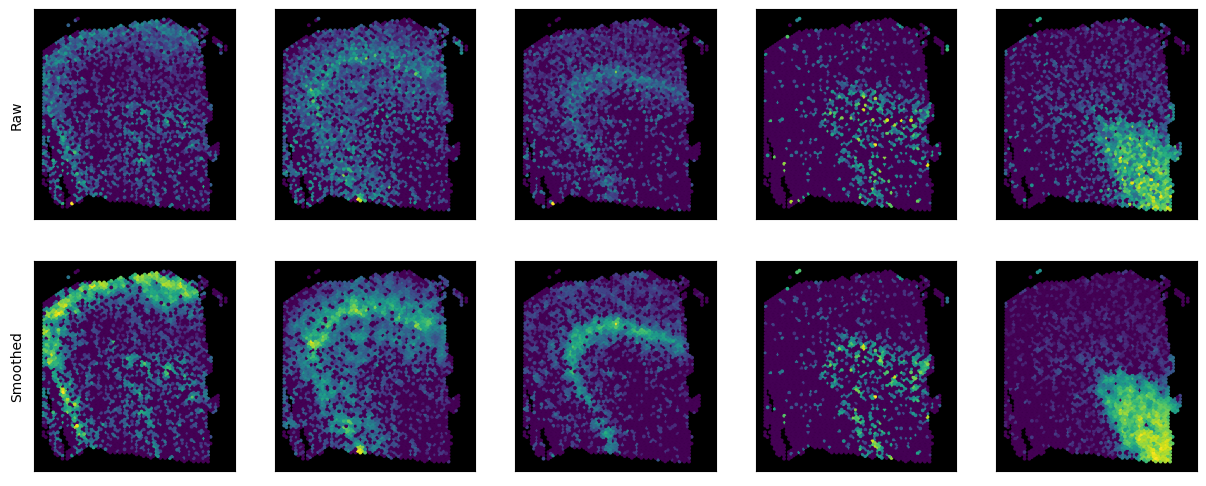

In [6]:
fig, axs = plt.subplots(ncols=len(ft_ind), nrows = 2, figsize = [3*len(ft_ind), 3*2])
for i, ax_col in enumerate(axs.T):
    ax_col[0].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                      c = y_obs[:,i], s = 3)
    ax_col[1].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                      c = y_imp[:,i], s = 3)
    
    if i == 0:
        ax_col[0].set_ylabel('Raw')
        ax_col[1].set_ylabel('Smoothed')

for ax in axs.flatten():
    ax.set_facecolor('black')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

#### Missing data imputation (fixed observation)

In [7]:
# select genes to smooth
ft_ind = [110,209,250,308,35]

# select spots to mask out
obs_ind = np.arange(2000) # observed spots
ms_ind = [i for i in range(y.shape[1]) if i not in obs_ind] # missing spots
y_orig = y[ft_ind, :].T
y_obs = y[ft_ind, :][:, obs_ind].T
y_ms = y[ft_ind, :][:, ms_ind].T

# run imputation
m = ImputeTorch(y_obs, spatial_loss, fixed_obs = True, nonneg=True, lambda_spatial_loss = 1,
                lr = 1e-2, tol = 1e-8, max_epochs = -1, verbose = False)
y_imp = m.get_results()

=== Time  0.55s. Total epoch 589. Final loss: (total)  0.368. (spatial)  0.368.


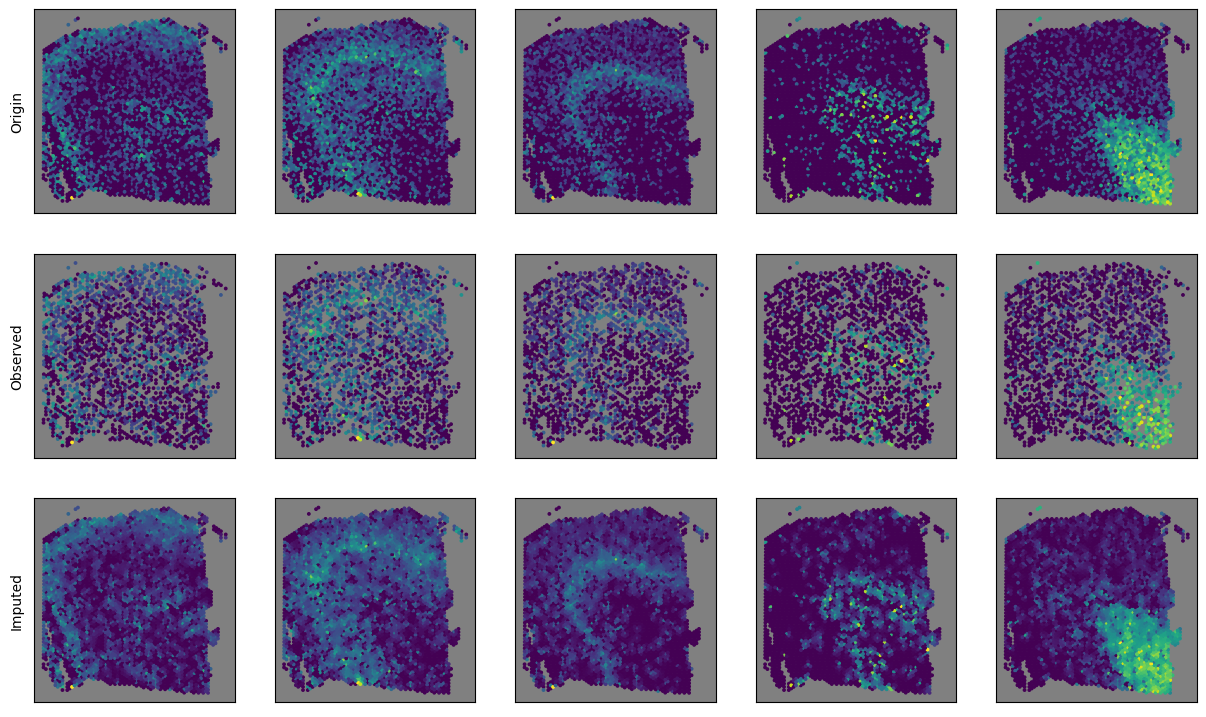

In [8]:
fig, axs = plt.subplots(ncols=len(ft_ind), nrows = 3, figsize = [3*len(ft_ind), 3*3])
for i, ax_col in enumerate(axs.T):
    ax_col[0].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                      c = y_orig[:,i], s = 3)
    ax_col[1].scatter(coords['pxl_col_in_fullres'][obs_ind], coords['pxl_row_in_fullres'][obs_ind],
                      c = y_obs[:,i], s = 3)
    ax_col[2].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                      c = y_imp[:,i], s = 3)
    
    if i == 0:
        ax_col[0].set_ylabel('Origin')
        ax_col[1].set_ylabel('Observed')
        ax_col[2].set_ylabel('Imputed')

for ax in axs.flatten():
    ax.set_facecolor('gray')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_37045/515326798.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817728005/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  ax_col[0].set_title(f"R = {scipy.stats.pearsonr(y_obs[:,i].T, y_imp[obs_ind,i].T)[0]:.3f}\n"+


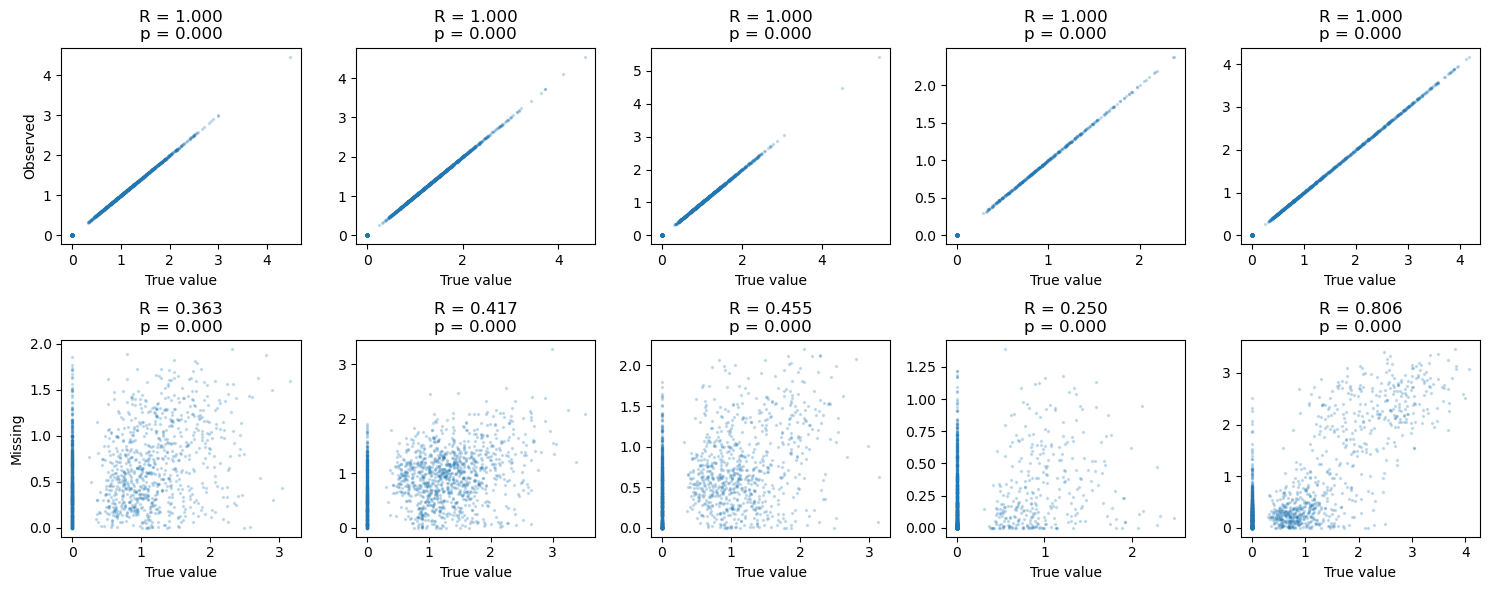

In [9]:
fig, axs = plt.subplots(ncols=len(ft_ind), nrows = 2, figsize = [3*len(ft_ind), 3*2])
for i, ax_col in enumerate(axs.T):
    ax_col[0].scatter(y_obs[:,i], y_imp[obs_ind,i], s = 2, alpha = 0.2)
    ax_col[0].set_title(f"R = {scipy.stats.pearsonr(y_obs[:,i].T, y_imp[obs_ind,i].T)[0]:.3f}\n"+
                        f"p = {scipy.stats.pearsonr(y_obs[:,i].T, y_imp[obs_ind,i].T)[1]:.3f}")
    ax_col[1].scatter(y_ms[:,i], y_imp[ms_ind,i], s = 2, alpha = 0.2)
    ax_col[1].set_title(f"R = {scipy.stats.pearsonr(y_ms[:,i].T, y_imp[ms_ind,i].T)[0]:.3f}\n"+
                        f"p = {scipy.stats.pearsonr(y_ms[:,i].T, y_imp[ms_ind,i].T)[1]:.3f}")
    
    if i == 0:
        ax_col[0].set_ylabel('Observed')
        ax_col[1].set_ylabel('Missing')

for ax in axs.flatten():
    ax.set_xlabel('True value')

plt.tight_layout()
plt.show()

#### Missing data imputation (flexible observation)

In [10]:
# select genes to smooth
ft_ind = [110,209,250,308,35]

# select spots to mask out
obs_ind = np.arange(2000) # observed spots
ms_ind = [i for i in range(y.shape[1]) if i not in obs_ind] # missing spots
y_orig = y[ft_ind, :].T
y_obs = y[ft_ind, :][:, obs_ind].T
y_ms = y[ft_ind, :][:, ms_ind].T


# run imputation
m = ImputeTorch(y_obs, spatial_loss, fixed_obs = False, nonneg=True, lambda_spatial_loss = 1,
                lr = 1e-2, tol = 1e-8, max_epochs = -1, verbose = False)
y_imp = m.get_results()

=== Time  0.78s. Total epoch 728. Final loss: (total)  0.210. (spatial)  0.131.


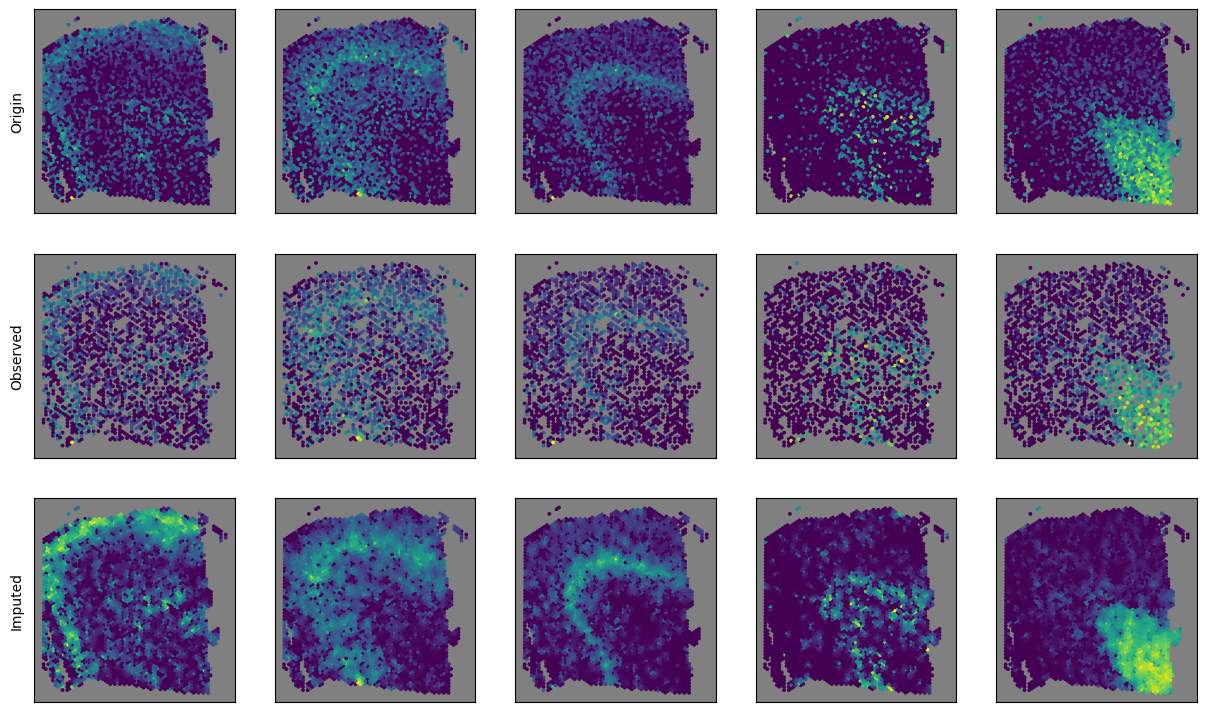

In [11]:
fig, axs = plt.subplots(ncols=len(ft_ind), nrows = 3, figsize = [3*len(ft_ind), 3*3])
for i, ax_col in enumerate(axs.T):
    ax_col[0].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                      c = y_orig[:,i], s = 3)
    ax_col[1].scatter(coords['pxl_col_in_fullres'][obs_ind], coords['pxl_row_in_fullres'][obs_ind],
                      c = y_obs[:,i], s = 3)
    ax_col[2].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                      c = y_imp[:,i], s = 3)
    
    if i == 0:
        ax_col[0].set_ylabel('Origin')
        ax_col[1].set_ylabel('Observed')
        ax_col[2].set_ylabel('Imputed')

for ax in axs.flatten():
    ax.set_facecolor('gray')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

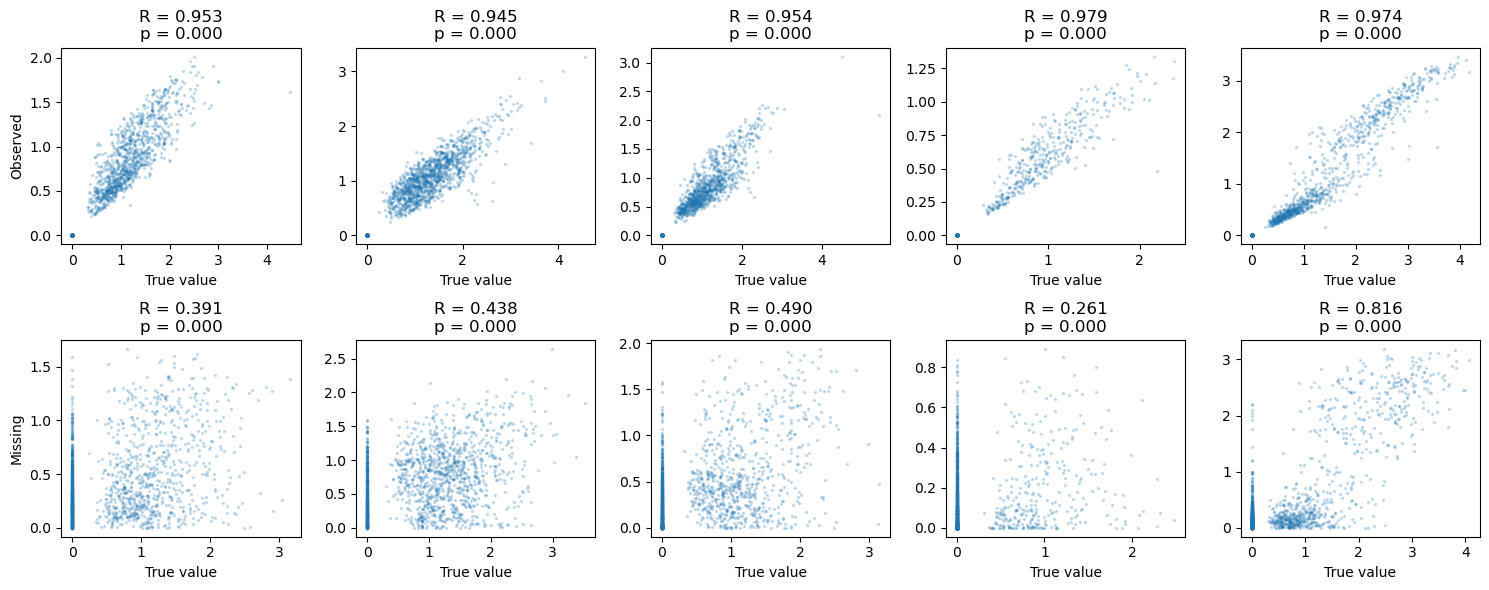

In [12]:
fig, axs = plt.subplots(ncols=len(ft_ind), nrows = 2, figsize = [3*len(ft_ind), 3*2])
for i, ax_col in enumerate(axs.T):
    ax_col[0].scatter(y_obs[:,i], y_imp[obs_ind,i], s = 2, alpha = 0.2)
    ax_col[0].set_title(f"R = {scipy.stats.pearsonr(y_obs[:,i].T, y_imp[obs_ind,i].T)[0]:.3f}\n"+
                        f"p = {scipy.stats.pearsonr(y_obs[:,i].T, y_imp[obs_ind,i].T)[1]:.3f}")
    ax_col[1].scatter(y_ms[:,i], y_imp[ms_ind,i], s = 2, alpha = 0.2)
    ax_col[1].set_title(f"R = {scipy.stats.pearsonr(y_ms[:,i].T, y_imp[ms_ind,i].T)[0]:.3f}\n"+
                        f"p = {scipy.stats.pearsonr(y_ms[:,i].T, y_imp[ms_ind,i].T)[1]:.3f}")
    
    if i == 0:
        ax_col[0].set_ylabel('Observed')
        ax_col[1].set_ylabel('Missing')

for ax in axs.flatten():
    ax.set_xlabel('True value')

plt.tight_layout()
plt.show()

### (Optional) Data imputation using CVXPY-based implementations

**Note:** In general, CVXPY-based imputation is more accurate but slightly slower. When the number of genes to impute is large, CVXPY may encounter numeric issues.

In [13]:
# please make sure cvxpy is installed
from smoother.models.impute import ImputeConvex

#### Spatial feature (observed) smoothing

In [14]:
# select genes to smooth
ft_ind = [110,209,250,308,35]

y_obs = y[ft_ind,:].T

# run imputation
m = ImputeConvex(y_obs, spatial_loss, fixed_obs = False, nonneg=True, lambda_spatial_loss = 1)
y_imp = m.get_results()

=== Time  0.28s. Loss: (total)  0.220, (recon)  0.139, (spatial)  0.082


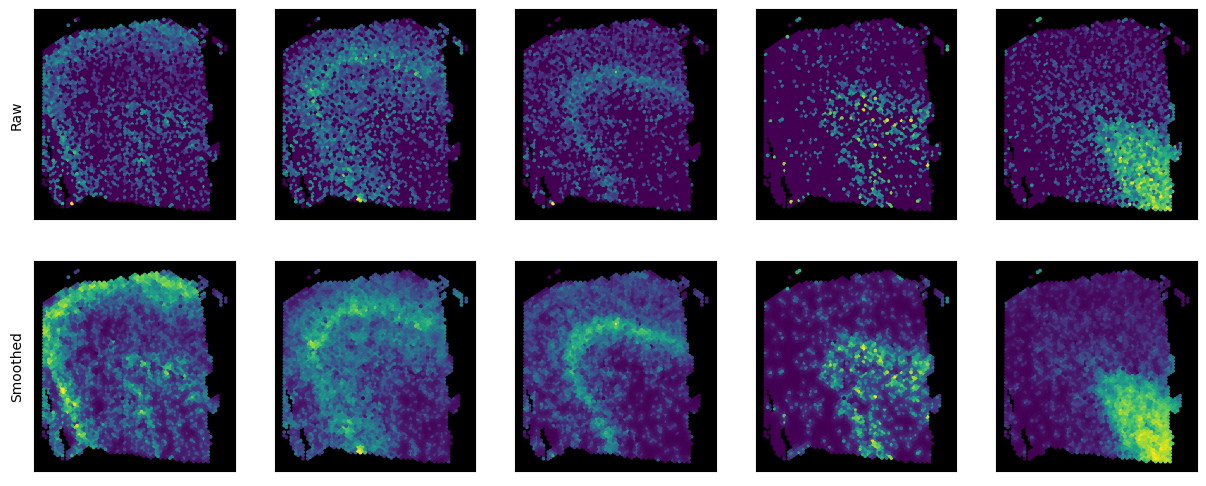

In [15]:
fig, axs = plt.subplots(ncols=len(ft_ind), nrows = 2, figsize = [3*len(ft_ind), 3*2])
for i, ax_col in enumerate(axs.T):
    ax_col[0].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                      c = y_obs[:,i], s = 3)
    ax_col[1].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                      c = y_imp[:,i], s = 3)
    
    if i == 0:
        ax_col[0].set_ylabel('Raw')
        ax_col[1].set_ylabel('Smoothed')

for ax in axs.flatten():
    ax.set_facecolor('black')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

#### Missing data imputation

In [16]:
# select genes to smooth
ft_ind = [110,209,250,308,35]

# select spots to mask out
obs_ind = np.arange(2000) # observed spots
ms_ind = [i for i in range(y.shape[1]) if i not in obs_ind] # missing spots
y_orig = y[ft_ind, :].T
y_obs = y[ft_ind, :][:, obs_ind].T
y_ms = y[ft_ind, :][:, ms_ind].T

# run imputation
m = ImputeConvex(y_obs, spatial_loss, fixed_obs = True, nonneg=True, lambda_spatial_loss = 1)
y_imp = m.get_results()

=== Time  0.16s. Loss: (total)  0.368, (recon)  0.000, (spatial)  0.368


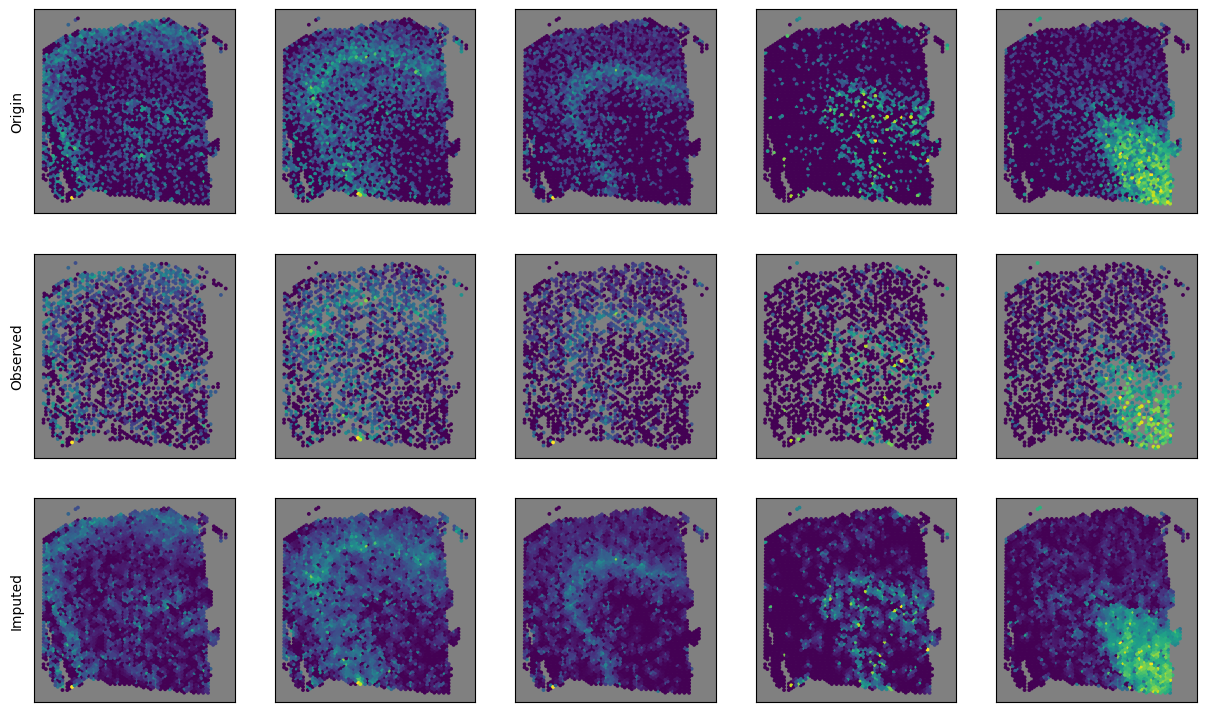

In [17]:
fig, axs = plt.subplots(ncols=len(ft_ind), nrows = 3, figsize = [3*len(ft_ind), 3*3])
for i, ax_col in enumerate(axs.T):
    ax_col[0].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                      c = y_orig[:,i], s = 3)
    ax_col[1].scatter(coords['pxl_col_in_fullres'][obs_ind], coords['pxl_row_in_fullres'][obs_ind],
                      c = y_obs[:,i], s = 3)
    ax_col[2].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                      c = y_imp[:,i], s = 3)
    
    if i == 0:
        ax_col[0].set_ylabel('Origin')
        ax_col[1].set_ylabel('Observed')
        ax_col[2].set_ylabel('Imputed')

for ax in axs.flatten():
    ax.set_facecolor('gray')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

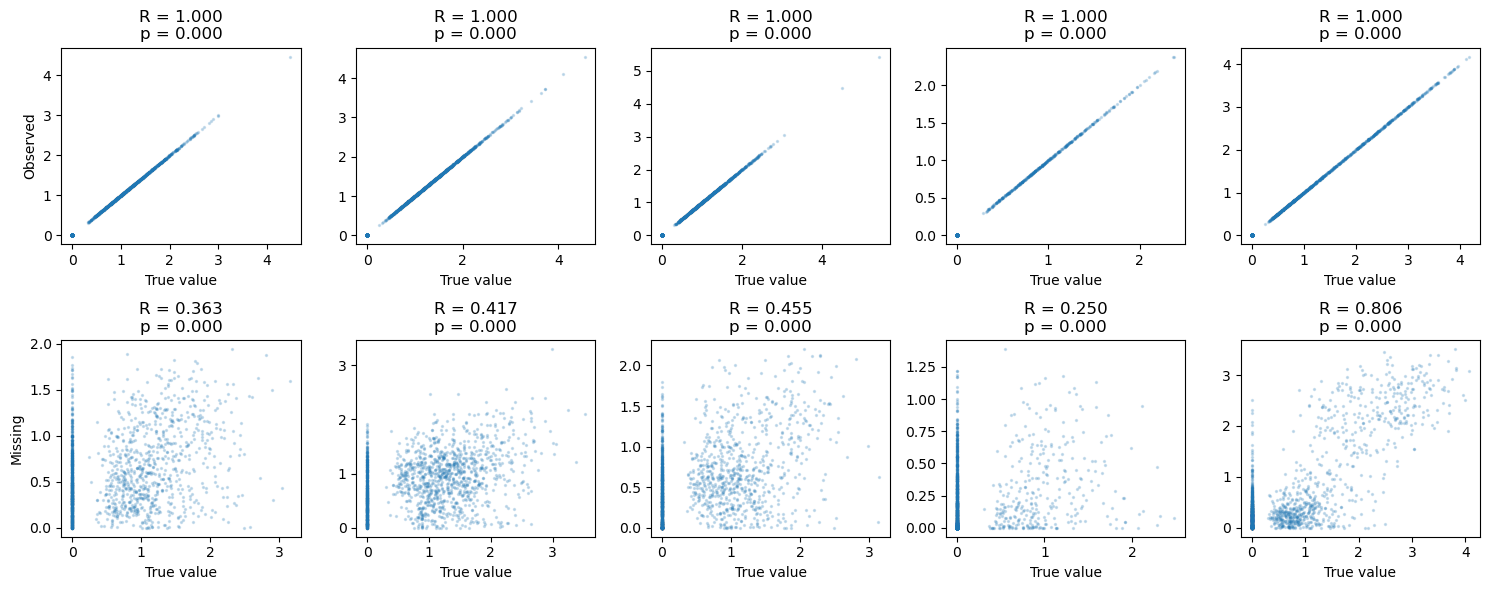

In [18]:
fig, axs = plt.subplots(ncols=len(ft_ind), nrows = 2, figsize = [3*len(ft_ind), 3*2])
for i, ax_col in enumerate(axs.T):
    ax_col[0].scatter(y_obs[:,i], y_imp[obs_ind,i], s = 2, alpha = 0.2)
    ax_col[0].set_title(f"R = {scipy.stats.pearsonr(y_obs[:,i].T, y_imp[obs_ind,i].T)[0]:.3f}\n"+
                        f"p = {scipy.stats.pearsonr(y_obs[:,i].T, y_imp[obs_ind,i].T)[1]:.3f}")
    ax_col[1].scatter(y_ms[:,i], y_imp[ms_ind,i], s = 2, alpha = 0.2)
    ax_col[1].set_title(f"R = {scipy.stats.pearsonr(y_ms[:,i].T, y_imp[ms_ind,i].T)[0]:.3f}\n"+
                        f"p = {scipy.stats.pearsonr(y_ms[:,i].T, y_imp[ms_ind,i].T)[1]:.3f}")
    
    if i == 0:
        ax_col[0].set_ylabel('Observed')
        ax_col[1].set_ylabel('Missing')

for ax in axs.flatten():
    ax.set_xlabel('True value')

plt.tight_layout()
plt.show()

#### Missing data imputation (flexible observation)

In [19]:
# select genes to smooth
ft_ind = [110,209,250,308]

# select spots to mask out
obs_ind = np.arange(2000) # observed spots
ms_ind = [i for i in range(y.shape[1]) if i not in obs_ind] # missing spots
y_orig = y[ft_ind, :].T
y_obs = y[ft_ind, :][:, obs_ind].T
y_ms = y[ft_ind, :][:, ms_ind].T

# run imputation
m = ImputeConvex(y_obs, spatial_loss, fixed_obs = False, nonneg=True, lambda_spatial_loss = 1)
y_imp = m.get_results()

=== Time  0.17s. Loss: (total)  0.173, (recon)  0.085, (spatial)  0.088


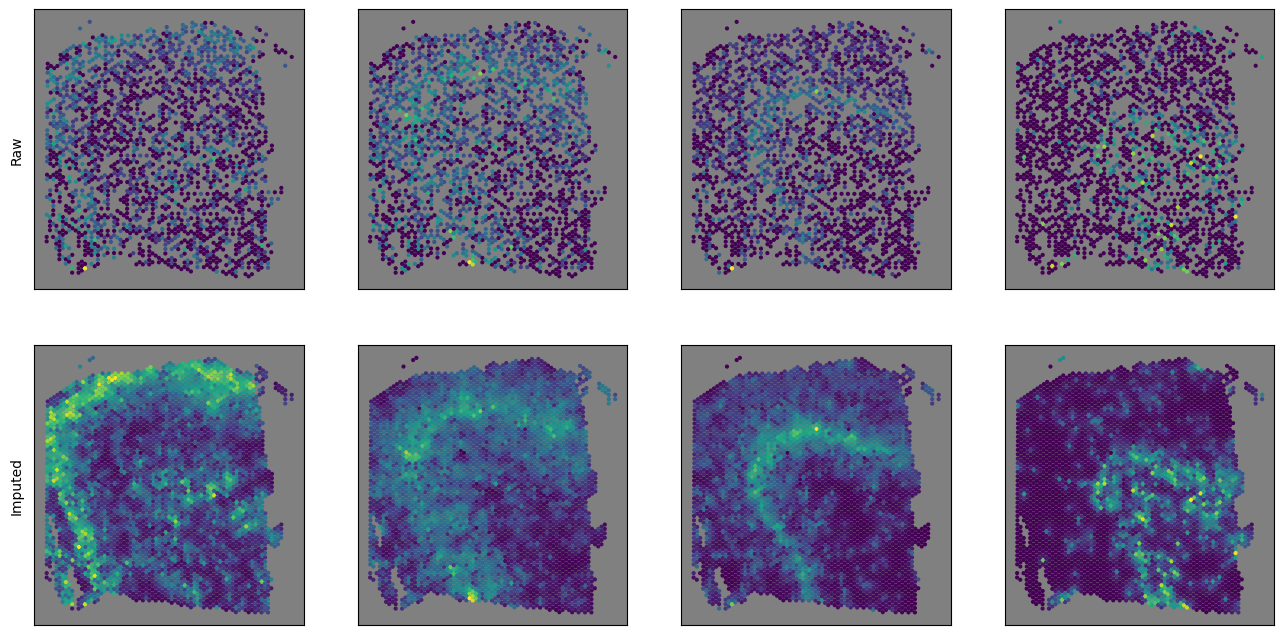

In [20]:
fig, axs = plt.subplots(ncols=len(ft_ind), nrows = 2, figsize = [4*len(ft_ind), 4*2])
for i, ax_col in enumerate(axs.T):
    ax_col[0].scatter(coords['pxl_col_in_fullres'][obs_ind], coords['pxl_row_in_fullres'][obs_ind],
                      c = y_obs[:,i], s = 4)
    ax_col[1].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                      c = y_imp[:,i], s = 4)
    
    if i == 0:
        ax_col[0].set_ylabel('Raw')
        ax_col[1].set_ylabel('Imputed')

for ax in axs.flatten():
    ax.set_facecolor('gray')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

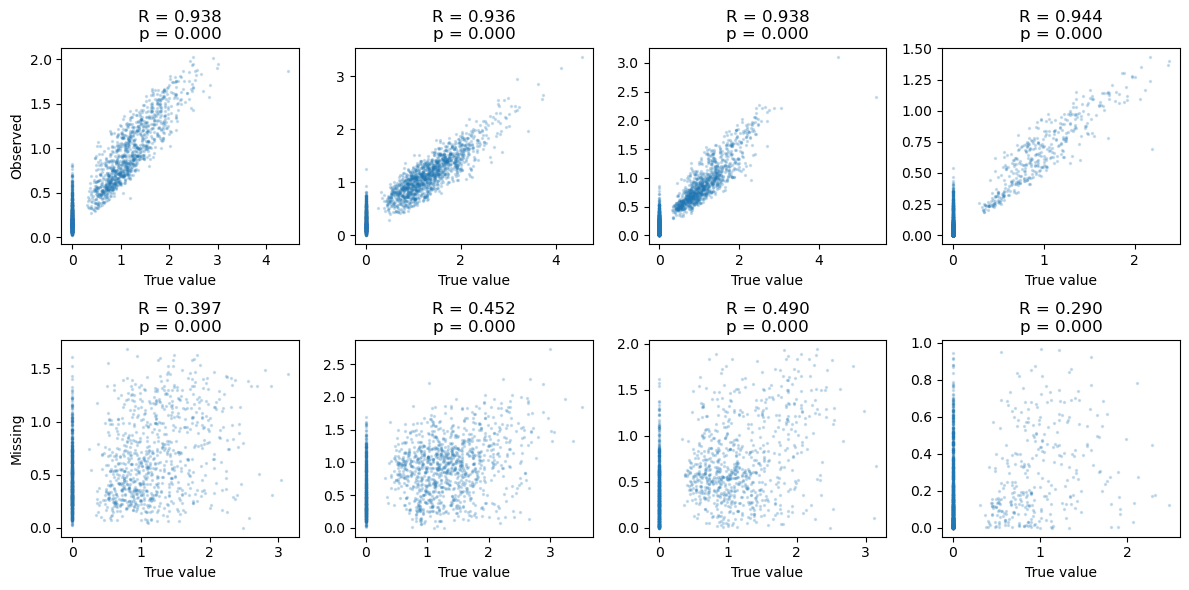

In [21]:
fig, axs = plt.subplots(ncols=len(ft_ind), nrows = 2, figsize = [3*len(ft_ind), 3*2])
for i, ax_col in enumerate(axs.T):
    ax_col[0].scatter(y_obs[:,i], y_imp[obs_ind,i], s = 2, alpha = 0.2)
    ax_col[0].set_title(f"R = {scipy.stats.pearsonr(y_obs[:,i].T, y_imp[obs_ind,i].T)[0]:.3f}\n"+
                        f"p = {scipy.stats.pearsonr(y_obs[:,i].T, y_imp[obs_ind,i].T)[1]:.3f}")
    ax_col[1].scatter(y_ms[:,i], y_imp[ms_ind,i], s = 2, alpha = 0.2)
    ax_col[1].set_title(f"R = {scipy.stats.pearsonr(y_ms[:,i].T, y_imp[ms_ind,i].T)[0]:.3f}\n"+
                        f"p = {scipy.stats.pearsonr(y_ms[:,i].T, y_imp[ms_ind,i].T)[1]:.3f}")
    
    if i == 0:
        ax_col[0].set_ylabel('Observed')
        ax_col[1].set_ylabel('Missing')

for ax in axs.flatten():
    ax.set_xlabel('True value')

plt.tight_layout()
plt.show()